In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [153]:
df = pd.read_csv('POMO4 Dados Históricos.csv', parse_dates = ['Data'], dayfirst = True, decimal = ',')
df = df.drop(['Var%'], axis = 1)
df = df.sort_index(ascending = False).reset_index().drop(['index'], axis = 1)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.
0,2005-01-03,0.56,0.56,0.56,0.56,"6,02M"
1,2005-01-04,0.56,0.56,0.57,0.56,"1,89M"
2,2005-01-05,0.56,0.57,0.57,0.56,"2,20M"
3,2005-01-06,0.56,0.56,0.57,0.56,"903,95K"
4,2005-01-07,0.56,0.55,0.57,0.55,"2,34M"


In [154]:
df['Vol.'] = df['Vol.'].str.replace(',', '.').str.replace('[MK]', '').astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3991 entries, 0 to 3990
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3991 non-null   datetime64[ns]
 1   Último    3991 non-null   float64       
 2   Abertura  3991 non-null   float64       
 3   Máxima    3991 non-null   float64       
 4   Mínima    3991 non-null   float64       
 5   Vol.      3991 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 187.2 KB


In [155]:
df = df.rename(columns = {
    'Data': 'Date',
    'Último': 'Close',
    'Abertura': 'Open',
    'Máxima': 'High',
    'Mínima': 'Low',
    'Vol.': 'Volume'
})

df['Next Day Close'] = df['Close'].shift(-1)
df['Next 5th Day Close'] = df['Close'].shift(-5)

df = df.dropna()
df = df.reset_index().drop(['index'], axis = 1)

In [156]:
df.tail()

,Date,Close,Open,High,Low,Volume,Next Day Close,Next 5th Day Close
3981,2021-02-09,2.80,2.83,2.85,2.78,10.23,2.76,2.63
3982,2021-02-10,2.76,2.81,2.82,2.73,7.94,2.74,2.62
3983,2021-02-11,2.74,2.78,2.81,2.72,6.81,2.74,2.52
3984,2021-02-12,2.74,2.75,2.76,2.71,5.18,2.66,2.62
3985,2021-02-17,2.66,2.75,2.76,2.64,11.96,2.63,2.67


## Data Preparation

In [157]:
X_train = df[:3000].drop(['Date', 'Next Day Close', 'Next 5th Day Close'], axis = 1)
X_test = df[3000:].drop(['Date', 'Next Day Close', 'Next 5th Day Close'], axis = 1)

y1_train = df[:3000]['Next Day Close']
y1_test = df[3000:]['Next Day Close']

y5_train = df[:3000]['Next 5th Day Close']
y5_test = df[3000:]['Next 5th Day Close']

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Baseline model and model selection

In [159]:
from sklearn.metrics import mean_squared_error

baseline_y1 = np.ones(len(y1_test)) * y1_train.mean()
rmse_baseline_y1 = np.sqrt(mean_squared_error(y1_test, baseline_y1))

baseline_y5 = np.ones(len(y5_test)) * y5_train.mean()
rmse_baseline_y5 = np.sqrt(mean_squared_error(y5_test, baseline_y5))

print('Baseline RMSE of the next day prediction: {} R$'.format(rmse_baseline_y1))
print('Baseline RMSE of the next 5th day prediction: {} R$'.format(rmse_baseline_y5))

Baseline RMSE of the next day prediction: 1.3352544392545893 R$
Baseline RMSE of the next 5th day prediction: 1.332066348232169 R$


In [160]:
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

for model in [SGDRegressor(), LinearRegression(), Ridge(), LinearSVR(max_iter = 100000), RandomForestRegressor()]:

    mdl1 = model
    mdl1.fit(X_train, y1_train)
    pred_mdl1 = mdl1.predict(X_test)
    rmse_mdl1 = np.sqrt(mean_squared_error(y1_test, pred_mdl1))

    mdl5 = model
    mdl5.fit(X_train, y5_train)
    pred_mdl5 = mdl5.predict(X_test)
    rmse_mdl5 = np.sqrt(mean_squared_error(y5_test, pred_mdl5))

    print('\n{} RMSE for the next day prediction: {} R$'.format(model, rmse_mdl1))
    print('{} RMSE for the next 5th day prediction: {} R$'.format(model, rmse_mdl5))


SGDRegressor() RMSE for the next day prediction: 0.10597486817481166 R$
SGDRegressor() RMSE for the next 5th day prediction: 0.2276721510799441 R$

LinearRegression() RMSE for the next day prediction: 0.09775777726831528 R$
LinearRegression() RMSE for the next 5th day prediction: 0.22519126724376576 R$

Ridge() RMSE for the next day prediction: 0.09866993092840891 R$
Ridge() RMSE for the next 5th day prediction: 0.2252827013864185 R$

LinearSVR(max_iter=100000) RMSE for the next day prediction: 0.0979419486937616 R$
LinearSVR(max_iter=100000) RMSE for the next 5th day prediction: 0.22476422065926807 R$

RandomForestRegressor() RMSE for the next day prediction: 0.10524173564177149 R$
RandomForestRegressor() RMSE for the next 5th day prediction: 0.23989585956855078 R$


# Next day predictors

In [161]:
rmses_r1 = []

for alpha in np.arange(0.1, 2, 0.001):
    
    r1 = Ridge(alpha = alpha)
    r1.fit(X_train, y1_train)
    pred_r1 = r1.predict(X_test)
    rmse_r1 = np.sqrt(mean_squared_error(y1_test, pred_r1))

    rmses_r1.append([rmse_r1, alpha])
    
print('Best alpha: {}'.format(min(rmses_r1)[1]))
print('Best Ridge Regression RMSE for the next day prediction: R$ {}'.format(min(rmses_r1)[0]))

best_r1 = Ridge(alpha = min(rmses_r1)[1])
best_r1.fit(X_train, y1_train)
pred_best_r1 = best_r1.predict(X_test)

Best alpha: 0.1
Best Ridge Regression RMSE for the next day prediction: R$ 0.09771651510957217


In [11]:
rmses_svr1 = []

for C in np.arange(0.01, 2, 0.005):

    svr1 = LinearSVR(C = C)
    svr1.fit(X_train, y1_train)
    pred_svr1 = svr1.predict(X_test)
    rmse_svr1 = np.sqrt(mean_squared_error(y1_test, pred_svr1))

    rmses_svr1.append([rmse_svr1, C])
    
print('Best C: {}'.format(min(rmses_svr1)[1]))
print('Best Linear SVR RMSE for the next day prediction: R$ {}'.format(min(rmses_svr1)[0]))

best_svr1 = LinearSVR(C = min(rmses_svr1)[1])
best_svr1.fit(X_train, y1_train)
pred_best_svr1 = best_svr1.predict(X_test)

Best C: 0.6799999999999999
Best Linear SVR RMSE for the next day prediction: R$ 0.0977672888616121


In [162]:
lr1 = LinearRegression()
lr1.fit(X_train, y1_train)
pred_lr1 = lr1.predict(X_test)

print('Linear Regression RMSE for the nextday prediction: R$ {}'.format(np.sqrt(mean_squared_error(y1_test, pred_lr1))))

Linear Regression RMSE for the nextday prediction: R$ 0.09775777726831528


In [163]:
next_day = pd.DataFrame({'Date': df[3000:]['Date'], 'Next Day Close': y1_test,
              'Ridge Prediction': pred_best_r1, 'SVR Prediction': pred_best_svr1, 'Linear Regression Prediction': pred_lr1,
            'Ridge Error': (pred_best_r1 - y1_test), 'SVR Error': (pred_best_svr1 - y1_test), 'Linear Regression Error': (pred_lr1 - y1_test)})

conditions = [
    np.logical_and(abs(next_day['Ridge Error']) < abs(next_day['SVR Error']), abs(next_day['Ridge Error']) < abs(next_day['Linear Regression Error'])),
    np.logical_and(abs(next_day['SVR Error']) < abs(next_day['Ridge Error']), abs(next_day['SVR Error']) < abs(next_day['Linear Regression Error'])),
    np.logical_and(abs(next_day['Linear Regression Error']) < abs(next_day['SVR Error']), abs(next_day['Linear Regression Error']) < abs(next_day['Ridge Error']))
]
choices = ['Ridge', 'SVR', 'Linear Regression']
next_day['Best Model'] = np.select(conditions, choices)

next_day

,Date,Next Day Close,Ridge Prediction,SVR Prediction,Linear Regression Prediction,Ridge Error,SVR Error,Linear Regression Error,Best Model
3000,2017-02-16,2.92,2.936920,2.935442,2.938066,0.016920,0.015442,0.018066,SVR
3001,2017-02-17,2.89,2.919972,2.919783,2.920081,0.029972,0.029783,0.030081,SVR
3002,2017-02-20,2.88,2.897716,2.896571,2.895499,0.017716,0.016571,0.015499,Linear Regression
3003,2017-02-21,2.80,2.884671,2.883193,2.883398,0.084671,0.083193,0.083398,SVR
3004,2017-02-22,2.72,2.796889,2.796980,2.798114,0.076889,0.076980,0.078114,Ridge
...,...,...,...,...,...,...,...,...,...
3981,2021-02-09,2.76,2.802496,2.801799,2.801907,0.042496,0.041799,0.041907,SVR
3982,2021-02-10,2.74,2.761537,2.761313,2.761288,0.021537,0.021313,0.021288,Linear Regression
3983,2021-02-11,2.74,2.744464,2.743578,2.743337,0.004464,0.003578,0.003337,Linear Regression
3984,2021-02-12,2.66,2.739021,2.738308,2.739528,0.079021,0.078308,0.079528,SVR


In [164]:
print('Ridge RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_day['Ridge Error'])))))
print('SVR RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_day['SVR Error'])))))
print('Linear Regression RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_day['Linear Regression Error'])))))

Ridge RMSE: R$ 0.09771651510957217
SVR RMSE: R$ 0.09777324284305829
Linear Regression RMSE: R$ 0.09775777726831528


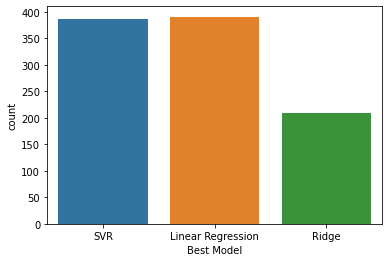

In [165]:
sns.countplot(next_day['Best Model'])
plt.show()

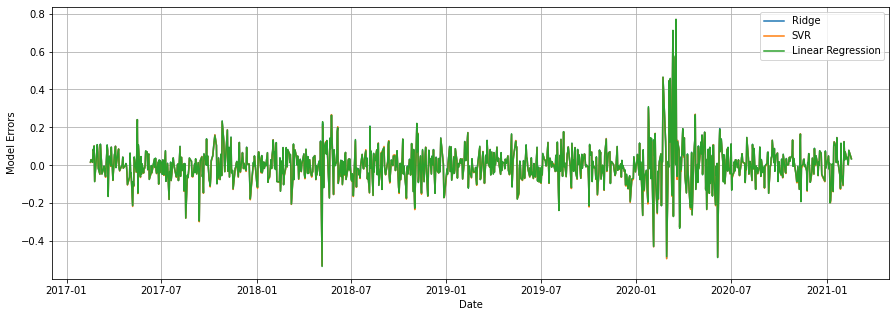

In [166]:
plt.figure(figsize = (15, 5))

sns.lineplot(data = next_day, x = 'Date',
             y = 'Ridge Error', label = 'Ridge')
sns.lineplot(data = next_day, x = 'Date',
             y = 'SVR Error', label = 'SVR')
sns.lineplot(data = next_day, x = 'Date',
             y = 'Linear Regression Error', label = 'Linear Regression')

plt.ylabel('Model Errors')
plt.grid()
plt.show()

# Next 5th day predictors

In [167]:
rmses_r5 = []

for alpha in np.arange(0.1, 2, 0.001):
    
    r5 = Ridge(alpha = alpha)
    r5.fit(X_train, y5_train)
    pred_r5 = r5.predict(X_test)
    rmse_r5 = np.sqrt(mean_squared_error(y5_test, pred_r5))

    rmses_r5.append([rmse_r5, alpha])
    
print('Best alpha: {}'.format(min(rmses_r5)[1]))
print('Best Ridge Regression RMSE for the next 5th day prediction: R$ {}'.format(min(rmses_r5)[0]))

best_r5 = Ridge(alpha = min(rmses_r5)[1])
best_r5.fit(X_train, y5_train)
pred_best_r5 = best_r5.predict(X_test)

Best alpha: 0.27400000000000013
Best Ridge Regression RMSE for the next 5th day prediction: R$ 0.22509159497145542


In [18]:
rmses_svr5 = []

for C in np.arange(0.01, 20, 0.25):

    svr5 = LinearSVR(C = C)
    svr5.fit(X_train, y5_train)
    pred_svr5 = svr5.predict(X_test)
    rmse_svr5 = np.sqrt(mean_squared_error(y5_test, pred_svr5))

    rmses_svr5.append([rmse_svr5, C])
    
print('Best C: {}'.format(min(rmses_svr5)[1]))
print('Best Linear SVR RMSE for the next 5th day prediction: R$ {}'.format(min(rmses_svr5)[0]))

best_svr5 = LinearSVR(C = min(rmses_svr5)[1])
best_svr5.fit(X_train, y5_train)
pred_best_svr5 = best_svr5.predict(X_test)

Best C: 17.26
Best Linear SVR RMSE for the next 5th day prediction: R$ 0.2229677821528336


In [168]:
lr5 = LinearRegression()
lr5.fit(X_train, y5_train)
pred_lr5 = lr5.predict(X_test)

print('Linear Regression RMSE for the next 5th day prediction: R$ {}'.format(np.sqrt(mean_squared_error(y5_test, pred_lr5))))

Linear Regression RMSE for the next 5th day prediction: R$ 0.22519126724376576


In [169]:
next_5th_day = pd.DataFrame({'Date': df[3000:]['Date'], 'Next 5th Day Close': y5_test,
                             'Ridge Prediction': pred_best_r5, 'SVR Prediction': pred_best_svr5, 'Linear Regression Prediction': pred_lr5,
                             'Ridge Error': (pred_best_r5 - y5_test), 'SVR Error': (pred_best_svr5 - y5_test), 'Linear Regression Error': (pred_lr5 - y5_test)})

conditions = [
    np.logical_and(abs(next_day['Ridge Error']) < abs(next_day['SVR Error']), abs(next_day['Ridge Error']) < abs(next_day['Linear Regression Error'])),
    np.logical_and(abs(next_day['SVR Error']) < abs(next_day['Ridge Error']), abs(next_day['SVR Error']) < abs(next_day['Linear Regression Error'])),
    np.logical_and(abs(next_day['Linear Regression Error']) < abs(next_day['SVR Error']), abs(next_day['Linear Regression Error']) < abs(next_day['Ridge Error']))
]
choices = ['Ridge', 'SVR', 'Linear Regression']
next_5th_day['Best Model'] = np.select(conditions, choices)

next_5th_day

,Date,Next 5th Day Close,Ridge Prediction,SVR Prediction,Linear Regression Prediction,Ridge Error,SVR Error,Linear Regression Error,Best Model
3000,2017-02-16,2.72,2.933207,2.891778,2.934901,0.213207,0.171778,0.214901,SVR
3001,2017-02-17,2.62,2.921484,2.876072,2.920984,0.301484,0.256072,0.300984,SVR
3002,2017-02-20,2.71,2.904712,2.850608,2.900592,0.194712,0.140608,0.190592,Linear Regression
3003,2017-02-21,2.60,2.887172,2.839217,2.884665,0.287172,0.239217,0.284665,SVR
3004,2017-02-22,2.54,2.801241,2.759248,2.802986,0.261241,0.219248,0.262986,Ridge
...,...,...,...,...,...,...,...,...,...
3981,2021-02-09,2.63,2.806312,2.762305,2.804879,0.176312,0.132305,0.174879,SVR
3982,2021-02-10,2.62,2.767447,2.723852,2.766600,0.147447,0.103852,0.146600,Linear Regression
3983,2021-02-11,2.52,2.750963,2.705841,2.748758,0.230963,0.185841,0.228758,Linear Regression
3984,2021-02-12,2.62,2.739211,2.703415,2.739571,0.119211,0.083415,0.119571,SVR


In [170]:
print('Ridge RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_5th_day['Ridge Error'])))))
print('SVR RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_5th_day['SVR Error'])))))
print('Linear Regression RMSE: R$ {}'.format(np.sqrt(np.mean(np.square(next_5th_day['Linear Regression Error'])))))

Ridge RMSE: R$ 0.22509159497145542
SVR RMSE: R$ 0.23084427828026682
Linear Regression RMSE: R$ 0.22519126724376576


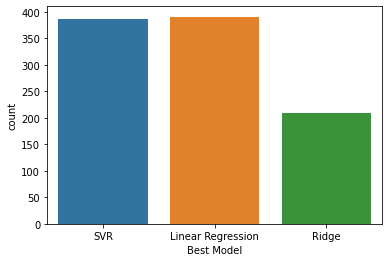

In [171]:
sns.countplot(next_5th_day['Best Model'])
plt.show()

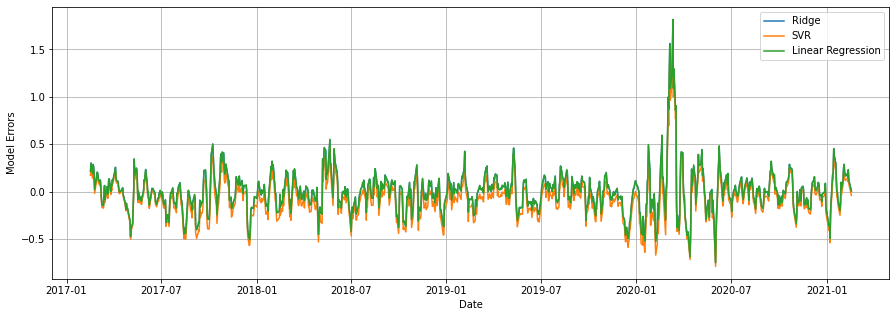

In [172]:
plt.figure(figsize = (15, 5))

sns.lineplot(data = next_5th_day, x = 'Date',
             y = 'Ridge Error', label = 'Ridge')
sns.lineplot(data = next_5th_day, x = 'Date',
             y = 'SVR Error', label = 'SVR')
sns.lineplot(data = next_5th_day, x = 'Date',
             y = 'Linear Regression Error', label = 'Linear Regression')

plt.ylabel('Model Errors')
plt.grid()
plt.show()

## New inputs

In [182]:
X = df[3900:].drop(['Date', 'Next Day Close', 'Next 5th Day Close'], axis = 1)
y1 = df[3900:]['Next Day Close']
y5 = df[3900:]['Next 5th Day Close']

scaler2 = StandardScaler()
X = scaler2.fit_transform(X)

new_lr1 = LinearRegression()
new_lr5 = LinearRegression()
new_lr1.fit(X, y1)
new_lr5.fit(X, y5)

new_svr1 = LinearSVR()
new_svr5 = LinearSVR()
new_svr1.fit(X, y1)
new_svr5.fit(X, y5)

new_r1 = Ridge()
new_r5 = Ridge()
new_r1.fit(X, y1)
new_r5.fit(X, y5)

Ridge()

In [183]:
def new_predictions(data, date):
    print(f'{date} Close: {data[0]}')
    
    print(f'\nTomorrow Predictions')
    print(f' Ridge: {new_r1.predict(scaler2.transform([data]))[0]}')
    print(f' SVR: {new_svr1.predict(scaler2.transform([data]))[0]}')
    print(f' Linear Regression: {new_lr1.predict(scaler2.transform([data]))[0]}')
    
    print('\nNext 5th Day Predictions')
    print(f' Ridge: {new_r5.predict(scaler2.transform([data]))[0]}')
    print(f' SVR: {new_svr5.predict(scaler2.transform([data]))[0]}')
    print(f' Linear Regression: {new_lr5.predict(scaler2.transform([data]))[0]}')

In [184]:
from datetime import datetime, date

def predictions(data, date):
    print(f'{date} Close: {data[0]}')
    
    print(f'\nTomorrow Predictions')
    print(f' Ridge: {r1.predict(scaler.transform([data]))[0]}')
    print(f' SVR: {svr1.predict(scaler.transform([data]))[0]}')
    print(f' Linear Regression: {lr1.predict(scaler.transform([data]))[0]}')
    
    print('\nNext 5th Day Predictions')
    print(f' Ridge: {r5.predict(scaler.transform([data]))[0]}')
    print(f' SVR: {svr5.predict(scaler.transform([data]))[0]}')
    print(f' Linear Regression: {lr5.predict(scaler.transform([data]))[0]}')

In [190]:
data_24 = [2.67, 2.65, 2.73, 2.63, 16.30]

predictions(data_24, '24/02/2021')
print()
new_predictions(data_24, '24/02/2021')

24/02/2021 Close: 2.67

Tomorrow Predictions
 Ridge: 2.674027472266153
 SVR: 2.6717986080678866
 Linear Regression: 2.6734070346452063

Next 5th Day Predictions
 Ridge: 2.6755619219923643
 SVR: 2.6378862106133254
 Linear Regression: 2.675156492091103

24/02/2021 Close: 2.67

Tomorrow Predictions
 Ridge: 2.7280284245026096
 SVR: 2.695930153455887
 Linear Regression: 2.7134993386492043

Next 5th Day Predictions
 Ridge: 2.750819777855293
 SVR: 2.7965495780740275
 Linear Regression: 2.739400371289349


In [191]:
data_18 = [2.63, 2.68, 2.70, 2.61, 9.70]
predictions(data_18, '18/02/2021')
print()
new_predictions(data_18, '18/02/2021')

18/02/2021 Close: 2.63

Tomorrow Predictions
 Ridge: 2.643496442965443
 SVR: 2.6342359154890604
 Linear Regression: 2.6330905704935303

Next 5th Day Predictions
 Ridge: 2.648095258812397
 SVR: 2.6013326456103076
 Linear Regression: 2.639653549056206

18/02/2021 Close: 2.63

Tomorrow Predictions
 Ridge: 2.6598660548704016
 SVR: 2.6468016827187557
 Linear Regression: 2.6533687502317544

Next 5th Day Predictions
 Ridge: 2.7134346427884504
 SVR: 2.7287106479872
 Linear Regression: 2.705792618142058
